# Introdução

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


df = pd.read_csv('/content/telexomX_BR_1.csv')
df.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,Permaneceu,Female,0,1,1,9,1,0,DSL,...,1,0,1,1,0,One year,1,Mailed check,65.6,593.30
1,0003-MKNFE,Permaneceu,Male,0,0,0,9,1,1,DSL,...,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40
2,0004-TLHLJ,Saiu,Male,0,0,0,4,1,0,Fiber optic,...,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,0011-IGKFF,Saiu,Male,1,1,0,13,1,0,Fiber optic,...,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,0013-EXCHZ,Saiu,Female,1,1,0,3,1,0,Fiber optic,...,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40


# Remoção de Colunas Irrelevantes

In [2]:
df.columns

Index(['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')

In [3]:
# Verificar colunas com valor único (sem variação)
unicas = [col for col in df.columns if df[col].nunique() == 1]

# Verificar colunas com 100% de valores ausentes
ausentes = [col for col in df.columns if df[col].isna().sum() == df.shape[0]]

# Verificar colunas que são identificadores
identificadores = [col for col in df.columns if 'id' in col.lower()]

# Juntar tudo
colunas_inuteis = list(set(unicas + ausentes + identificadores))

# Mostrar as colunas identificadas
print("Colunas consideradas inúteis para a modelagem:")
for col in colunas_inuteis:
    print(f" - {col}")
df.drop(columns=colunas_inuteis, inplace=True)

Colunas consideradas inúteis para a modelagem:
 - customerID


In [4]:
df.columns

Index(['Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')

# Verificação da Proporção de Evasão

In [5]:
# Verificar distribuição da variável-alvo
proporcao_churn = df['Churn'].value_counts(normalize=True)

# Exibir como percentual
print("📊 Proporção de clientes:")
print(proporcao_churn.map(lambda x: f"{x:.2%}"))

📊 Proporção de clientes:
Churn
Permaneceu    73.46%
Saiu          26.54%
Name: proportion, dtype: object


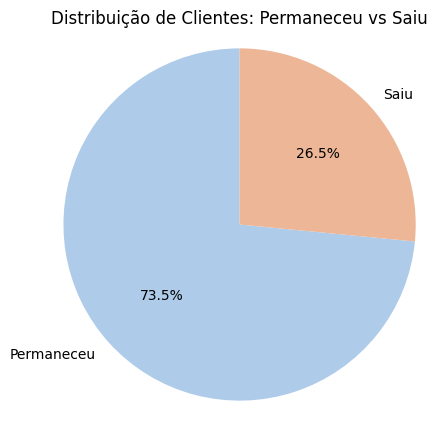

In [6]:
labels = df['Churn'].value_counts().index
sizes = df['Churn'].value_counts().values
colors = ['#aecbe9' if label == 'Permaneceu' else '#ecb697' for label in labels]

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribuição de Clientes: Permaneceu vs Saiu')
plt.axis('equal')
plt.show()


In [7]:
df['Churn'] = df['Churn'].map({'Permaneceu': 0, 'Saiu': 1})
df

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0,Female,0,1,1,9,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.60,593.30
1,0,Male,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.90,542.40
2,1,Male,0,0,0,4,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.90,280.85
3,1,Male,1,1,0,13,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.00,1237.85
4,1,Female,1,1,0,3,1,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.90,267.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,Female,0,0,0,13,1,0,DSL,1,0,0,1,0,0,One year,0,Mailed check,55.15,742.90
7039,1,Male,0,1,0,22,1,1,Fiber optic,0,0,0,0,0,1,Month-to-month,1,Electronic check,85.10,1873.70
7040,0,Male,0,0,0,2,1,0,DSL,0,1,0,0,0,0,Month-to-month,1,Mailed check,50.30,92.75
7041,0,Male,0,1,1,67,1,0,DSL,1,0,1,1,0,1,Two year,0,Mailed check,67.85,4627.65


In [8]:
x = df.drop('Churn', axis=1)
y = df['Churn']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
x_train_encoded = pd.get_dummies(x_train)
x_test_encoded = pd.get_dummies(x_test)
x_train_encoded, x_test_encoded = x_train_encoded.align(x_test_encoded, join='inner', axis=1, fill_value=0)
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_encoded, y_train)

print("Formato dos dados de treinamento originais: ", x_train.shape)
print("Formato dos dados de treinamento balanceados: ", x_train_smote.shape)
print("Formato dos rótulos de treinamento originais: ", y_train.shape)
print("Formato dos rótulos de treinamento balanceados: ", y_train_smote.shape)


Formato dos dados de treinamento originais:  (5634, 19)
Formato dos dados de treinamento balanceados:  (8278, 41)
Formato dos rótulos de treinamento originais:  (5634,)
Formato dos rótulos de treinamento balanceados:  (8278,)


# Verificando Normalização ou Padronização

In [11]:
col_numericas = x_train_encoded.select_dtypes(include=['int64', 'float64']).columns
col_numericas

Index(['customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents',
       'customer.tenure', 'phone.PhoneService', 'account.PaperlessBilling',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')

In [12]:
# Criar o scaler e ajustar apenas nos dados de treino
scaler = StandardScaler()
x_train_encoded_scaled = x_train_encoded.copy()
x_test_encoded_scaled = x_test_encoded.copy()

x_train_encoded_scaled[col_numericas] = scaler.fit_transform(x_train_encoded[col_numericas])
x_test_encoded_scaled[col_numericas] = scaler.transform(x_test_encoded[col_numericas])

# Análise de Correlação

In [13]:
df_numerico = df.select_dtypes(include=['int64', 'float64'])
correlacao = df_numerico.corr()

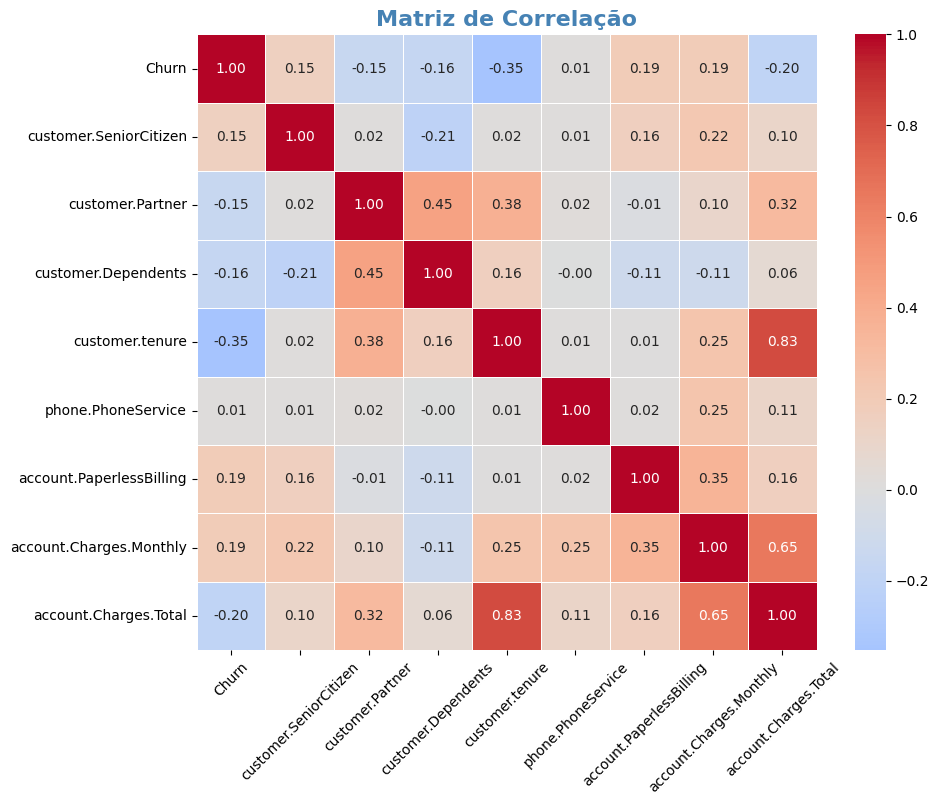

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matriz de Correlação', fontsize=16, weight='bold', color='steelblue')
plt.xticks(rotation=45)
plt.show()

In [15]:
corr_churn = correlacao['Churn'].drop('Churn')
corr_ordenada = corr_churn.abs().sort_values(ascending=False)
print(f'Colunas mais correlacionadas com churn:\n{corr_ordenada}')

Colunas mais correlacionadas com churn:
customer.tenure             0.352229
account.Charges.Total       0.199034
account.Charges.Monthly     0.193356
account.PaperlessBilling    0.191825
customer.Dependents         0.164221
customer.SeniorCitizen      0.150889
customer.Partner            0.150448
phone.PhoneService          0.011942
Name: Churn, dtype: float64


In [16]:
limiar = 0.2
var_select = corr_ordenada[corr_ordenada.abs() >= limiar].index.tolist()
print(f'Variáveis selecionadas com base na correlação: {var_select}')

Variáveis selecionadas com base na correlação: ['customer.tenure']


In [17]:
x_train_corr = x_train_encoded_scaled[var_select]
x_test_corr = x_test_encoded_scaled[var_select]
x_train_corr_sem_escala = x_train_encoded[var_select]
x_test_corr_sem_escala = x_test_encoded[var_select]

# Análises Direcionadas

/tmp/ipython-input-18-3263613905.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='customer.tenure',


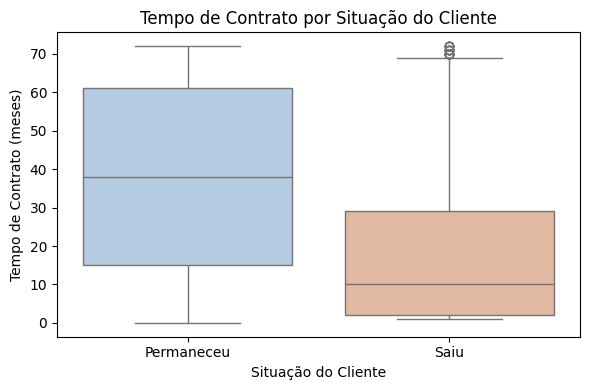

In [18]:
df['Churn'] = df['Churn'].replace({0: 'Permaneceu', 1: 'Saiu'})
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Churn', y='customer.tenure',
            palette={'Permaneceu': '#aecbe9', 'Saiu': '#ecb697'})
plt.title('Tempo de Contrato por Situação do Cliente')
plt.xlabel('Situação do Cliente')
plt.ylabel('Tempo de Contrato (meses)')
plt.tight_layout()
plt.show()

/tmp/ipython-input-19-4241781673.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='account.Charges.Total',


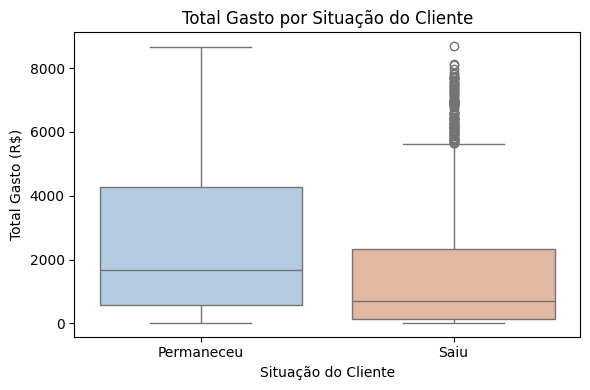

In [19]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Churn', y='account.Charges.Total',
            palette={'Permaneceu': '#aecbe9', 'Saiu': '#ecb697'})
plt.title('Total Gasto por Situação do Cliente')
plt.xlabel('Situação do Cliente')
plt.ylabel('Total Gasto (R$)')
plt.tight_layout()
plt.show()


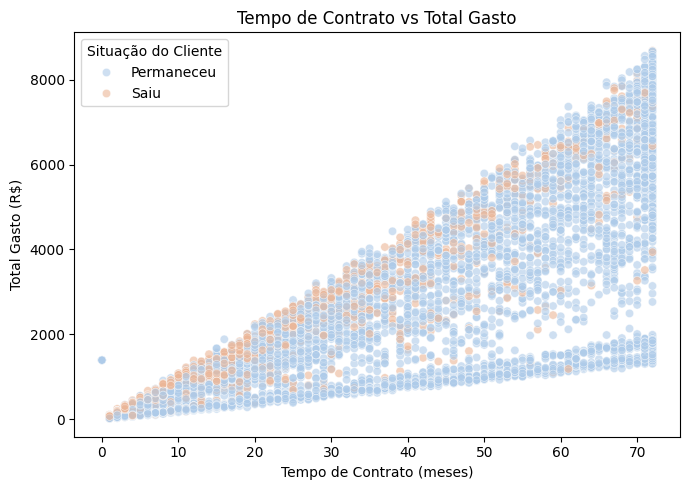

In [20]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df,
                x='customer.tenure',
                y='account.Charges.Total',
                hue='Churn',
                palette={'Permaneceu': '#aecbe9', 'Saiu': '#ecb697'},
                alpha=0.6)
plt.title('Tempo de Contrato vs Total Gasto')
plt.xlabel('Tempo de Contrato (meses)')
plt.ylabel('Total Gasto (R$)')
plt.legend(title='Situação do Cliente')
plt.tight_layout()
plt.show()


# Criação de Modelos

In [21]:
# Separar variável-alvo e preditores
X = df.drop(columns='Churn')
y = df['Churn']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# --- Modelo 1: Regressão Logística (com normalização) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

modelo_log = LogisticRegression(max_iter=1000)
modelo_log.fit(X_train_scaled, y_train)
y_pred_log = modelo_log.predict(X_test_scaled)

print("Regressão Logística:")
print(classification_report(y_test, y_pred_log))

# --- Modelo 2: Random Forest (sem normalização) ---
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)
y_pred_rf = modelo_rf.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))

# --- Modelo 3: KNN ---
modelo_knn = KNeighborsClassifier(n_neighbors=5)

# Treinar com os dados normalizados
modelo_knn.fit(X_train_scaled, y_train)

# Previsão (opcional)
y_pred_knn = modelo_knn.predict(X_test_scaled)

# Relatório completo (opcional, mostra precisão, recall, f1 por classe)
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_knn))


# --- Modelo 4: SVM com kernel linear ---
modelo_svm = SVC(kernel='linear', random_state=42)
modelo_svm.fit(X_train_scaled, y_train)

# Fazer a predição
y_pred_svm = modelo_svm.predict(X_test_scaled)

# Gerar o relatório de classificação
print("Relatório de Classificação - SVM Linear:")
print(classification_report(y_test, y_pred_svm))



Regressão Logística:
              precision    recall  f1-score   support

  Permaneceu       0.84      0.89      0.87      1552
        Saiu       0.64      0.54      0.59       561

    accuracy                           0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113

Random Forest:
              precision    recall  f1-score   support

  Permaneceu       0.83      0.89      0.86      1552
        Saiu       0.62      0.49      0.55       561

    accuracy                           0.78      2113
   macro avg       0.72      0.69      0.70      2113
weighted avg       0.77      0.78      0.78      2113


Relatório de Classificação:
              precision    recall  f1-score   support

  Permaneceu       0.82      0.83      0.83      1552
        Saiu       0.52      0.51      0.51       561

    accuracy                           0.74      2113
   macro avg       0.67      0.67      0.67      2113
weighted 

Avaliação dos Modelos

In [22]:
# --- Comparação das Métricas ---
from sklearn.metrics import precision_score, recall_score

# Função para calcular as métricas macro
def avaliar_modelo(nome, y_true, y_pred):
    return {
        'Modelo': nome,
        'Acurácia': accuracy_score(y_true, y_pred),
        'F1-score (macro)': f1_score(y_true, y_pred, average='macro'),
        'Precisão (macro)': precision_score(y_true, y_pred, average='macro'),
        'Recall (macro)': recall_score(y_true, y_pred, average='macro')
    }

# Avaliar cada modelo
resultados = [
    avaliar_modelo("Regressão Logística", y_test, y_pred_log),
    avaliar_modelo("Random Forest", y_test, y_pred_rf),
    avaliar_modelo("KNN", y_test, y_pred_knn),
    avaliar_modelo("SVM Linear", y_test, y_pred_svm)
]

# Criar DataFrame
df_resultados = pd.DataFrame(resultados)

# Exibir a tabela
print("\n📊 Comparação das Métricas de Avaliação:")
print(df_resultados.sort_values(by="F1-score (macro)", ascending=False).round(4))



📊 Comparação das Métricas de Avaliação:
                Modelo  Acurácia  F1-score (macro)  Precisão (macro)  \
0  Regressão Logística    0.7974            0.7267            0.7415   
3           SVM Linear    0.7913            0.7200            0.7324   
1        Random Forest    0.7847            0.7030            0.7240   
2                  KNN    0.7444            0.6697            0.6712   

   Recall (macro)  
0          0.7164  
3          0.7111  
1          0.6907  
2          0.6684  


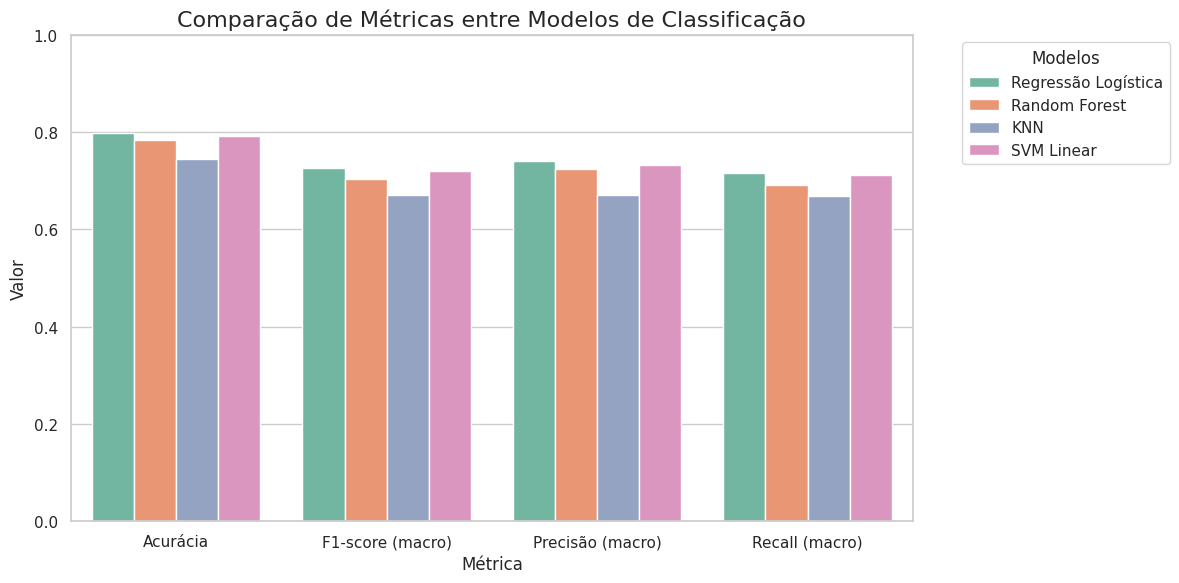

In [23]:
# Estilo do gráfico
sns.set(style="whitegrid")

# Reorganizar o DataFrame para formato longo (ideal para seaborn)
df_melted = df_resultados.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Métrica", y="Valor", hue="Modelo", palette="Set2")

plt.title("Comparação de Métricas entre Modelos de Classificação", fontsize=16)
plt.ylim(0, 1)
plt.legend(title="Modelos", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Análise de Importância das Variáveis

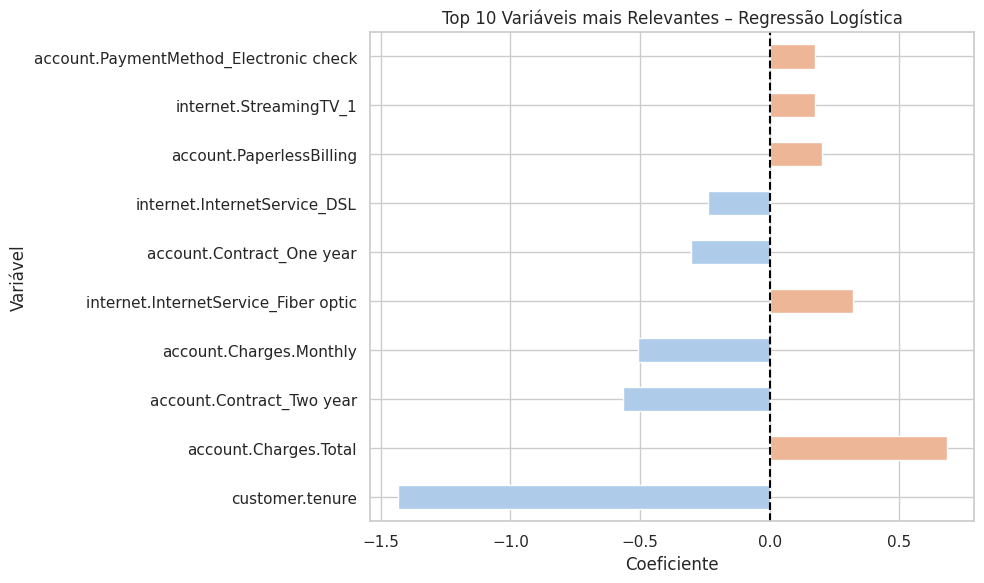

In [24]:
# Lista das colunas usadas no modelo (one-hot encoded)
colunas_modelo = X_train.columns  # Já tem as 30 colunas

# Coeficientes do modelo
coeficientes = pd.Series(modelo_log.coef_[0], index=colunas_modelo)

# Ordenar por magnitude (absoluto)
coef_ordenados = coeficientes.sort_values(key=abs, ascending=False)

# Visualizar os 10 mais influentes
plt.figure(figsize=(10, 6))
coef_ordenados.head(10).plot(kind='barh', color=['#ecb697' if v > 0 else '#aecbe9' for v in coef_ordenados.head(10)])
plt.title('Top 10 Variáveis mais Relevantes – Regressão Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Variável')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


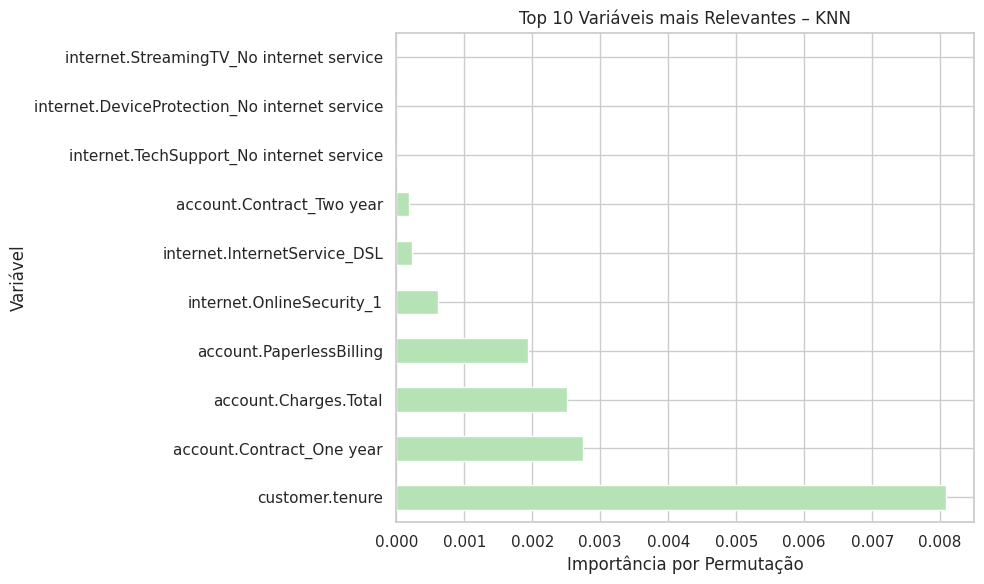

In [25]:
# Importância por permutação
resultado_knn = permutation_importance(modelo_knn, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Converter em Series e ordenar
importancias_knn = pd.Series(resultado_knn.importances_mean, index=X_train.columns).sort_values(ascending=False)

# Visualizar os 10 principais
plt.figure(figsize=(10,6))
importancias_knn.head(10).plot(kind='barh', color='#b5e3b5')
plt.title('Top 10 Variáveis mais Relevantes – KNN')
plt.xlabel('Importância por Permutação')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


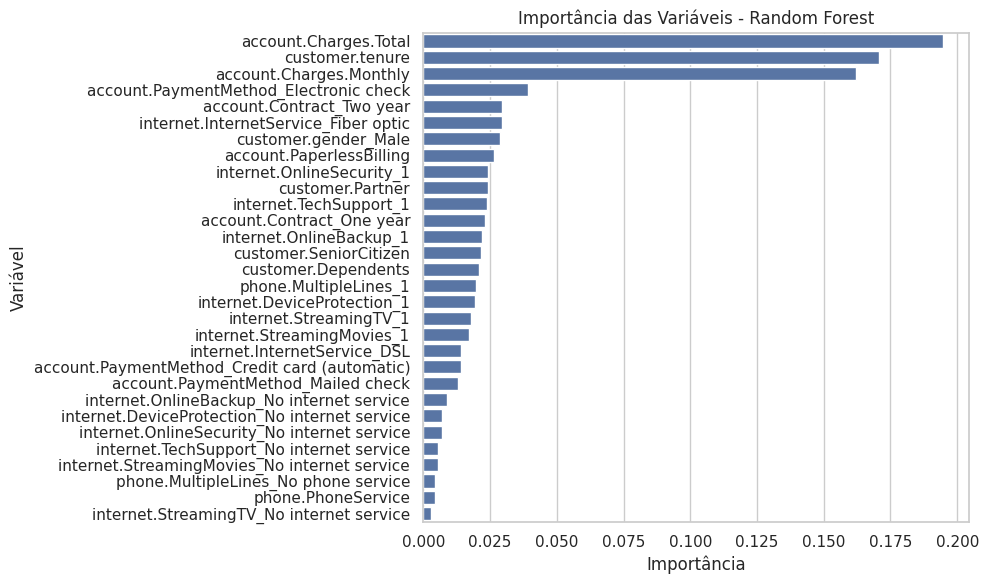

In [26]:
# Extrair as importâncias
importancias = modelo_rf.feature_importances_

# Como você aplicou get_dummies, os nomes das colunas podem ter mudado:
colunas = X_train.columns

# Criar um DataFrame para facilitar a visualização
df_importancias = pd.DataFrame({
    'Variável': colunas,
    'Importância': importancias
})

# Ordenar da maior para a menor importância
df_importancias = df_importancias.sort_values(by='Importância', ascending=False)

# Plotar
plt.figure(figsize=(10,6))
sns.barplot(x='Importância', y='Variável', data=df_importancias)
plt.title('Importância das Variáveis - Random Forest')
plt.tight_layout()
plt.show()


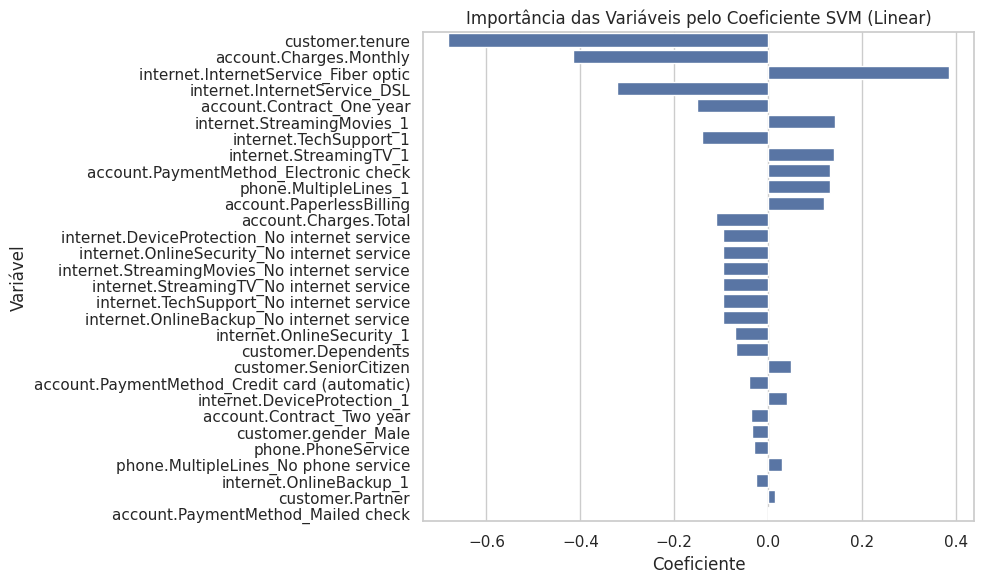

In [27]:
# Coeficientes das variáveis (forma: [1, n_features])
coeficientes = modelo_svm.coef_[0]

# Obter nomes das variáveis
colunas = X_train.columns

# Criar DataFrame com os coeficientes e variáveis
df_coef = pd.DataFrame({
    'Variável': colunas,
    'Coeficiente': coeficientes
})

# Calcular o valor absoluto para ordenação
df_coef['AbsCoef'] = df_coef['Coeficiente'].abs()

# Ordenar pelo valor absoluto
df_coef = df_coef.sort_values(by='AbsCoef', ascending=False)

# Plotar
plt.figure(figsize=(10,6))
sns.barplot(x='Coeficiente', y='Variável', data=df_coef)
plt.title('Importância das Variáveis pelo Coeficiente SVM (Linear)')
plt.tight_layout()
plt.show()


# Conclusão:

## Relatório Detalhado sobre Evasão de Clientes

Este relatório sumariza as descobertas da análise exploratória de dados e dos modelos de machine learning treinados para prever a evasão de clientes. O objetivo é identificar os principais fatores de risco e propor estratégias eficazes de retenção.

### 1. Análise de Correlação e Importância das Variáveis

A análise de correlação e a importância das variáveis (obtida dos modelos) revelaram insights importantes sobre quais fatores estão mais associados à evasão:

*   **Tempo de Contrato (`customer.tenure`):** Esta foi consistentemente uma das variáveis mais importantes em todos os modelos. Clientes com menor tempo de contrato (novos clientes) tendem a ter uma probabilidade maior de evasão. O boxplot demonstrou claramente essa diferença.
*   **Total Gasto (`account.Charges.Total`):** Embora menos correlacionado que o tempo de contrato, o total gasto também apareceu como um fator relevante, especialmente no modelo Random Forest. Clientes com gastos totais menores também tendem a evadir mais. O scatter plot mostrou que clientes que evadiram geralmente têm menor tempo de contrato e menor gasto total.
*   **Cobranças Mensais (`account.Charges.Monthly`):** As cobranças mensais também demonstraram alguma correlação com a evasão, sendo mais altas para clientes que evadiram.
*   **Serviço de Internet (Fibra Óptica vs. DSL):** A análise de importância das variáveis destacou que o tipo de serviço de internet, especialmente a Fibra Óptica, tem um impacto significativo na probabilidade de evasão (conforme observado nos coeficientes da Regressão Logística e SVM). Clientes com Fibra Óptica parecem ter maior chance de evadir.
*   **Suporte Técnico (`internet.TechSupport`):** A ausência de suporte técnico online também foi identificada como um fator de risco.
*   **Contrato (`account.Contract`):** Clientes com contratos de mês a mês têm uma probabilidade significativamente maior de evadir em comparação com contratos de um ou dois anos.
*   **Pagamento Online (`account.PaperlessBilling`):** Clientes que optam por contas online (`PaperlessBilling`) também apresentaram maior propensão à evasão.
*    **Método de Pagamento (Cheque Eletrônico):** O método de pagamento por cheque eletrônico também se mostrou um fator relevante associado à evasão.
*   **Serviços de Streaming (`internet.StreamingTV`, `internet.StreamingMovies`):** A presença desses serviços também influenciou a probabilidade de evasão em alguns modelos.

### 2. Desempenho dos Modelos

Avaliou-se o desempenho de quatro modelos de classificação na previsão de evasão: Regressão Logística, Random Forest, KNN e SVM Linear. As métricas principais (Acurácia, F1-score, Precisão e Recall - macro) foram comparadas:

| Modelo              | Acurácia | F1-score (macro) | Precisão (macro) | Recall (macro) |
|---------------------|----------|-----------------|-------------------|---------------|
| Regressão Logística | 0.7974   | 0.7267          | 0.7415            | 0.7164        |
| SVM Linear          | 0.7913   | 0.7200          | 0.7324            | 0.7111        |
| Random Forest       | 0.7847   | 0.7030          | 0.7240            | 0.6907        |
| KNN                 | 0.7444   | 0.6697          | 0.6712            | 0.6684        |

A **Regressão Logística** apresentou o melhor desempenho geral, com o maior F1-score macro, indicando um bom equilíbrio entre precisão e recall para ambas as classes (clientes que evadiram e permaneceram). O SVM Linear também teve um desempenho comparável. O Random Forest e o KNN tiveram resultados um pouco inferiores.

### 3. Principais Fatores de Risco de Evasão

Com base nas análises, os principais fatores de risco associados à evasão de clientes são:

*   **Clientes Novos (Baixo Tempo de Contrato):** Clientes com pouco tempo de relacionamento com a empresa são mais propensos a sair.
*   **Clientes com Fibra Óptica:** Contraintuitivamente, clientes com este serviço de internet mais avançado apresentam maior risco. Isso pode indicar problemas de qualidade, suporte ou expectativas não atendidas.
*   **Ausência de Suporte Técnico:** Clientes sem suporte técnico online são mais vulneráveis à evasão.
*   **Contratos de Mês a Mês:** A flexibilidade desse tipo de contrato parece facilitar a decisão de evadir.
*   **Contas Online (`PaperlessBilling`):** Clientes que optam por contas online podem estar menos engajados ou ter menos barreiras para sair.
*    **Método de Pagamento (Cheque Eletrônico):** Este método de pagamento também está associado a um maior risco de evasão.

### 4. Estratégias de Retenção Propostas

Com base nos fatores de risco identificados, as seguintes estratégias de retenção são propostas:

*   **Foco em Novos Clientes:** Implementar programas de onboarding robustos para novos clientes, com acompanhamento proativo, ofertas especiais nos primeiros meses e canais de suporte facilitados.
*   **Investigação da Evasão de Clientes com Fibra Óptica:** Realizar uma análise aprofundada sobre o motivo da evasão de clientes com serviço de Fibra Óptica. Isso pode envolver pesquisas de satisfação, análise de chamados de suporte e verificação da qualidade do serviço.
*   **Incentivar o Suporte Técnico Online:** Promover ativamente os canais de suporte técnico online e garantir sua eficiência. Considerar oferecer benefícios ou descontos para clientes que utilizam esses canais.
*   **Oferecer Incentivos para Contratos de Longo Prazo:** Criar ofertas atrativas para clientes que optam por contratos de um ou dois anos, destacando os benefícios e a economia a longo prazo.
*   **Engajamento de Clientes com Contas Online:** Desenvolver estratégias para aumentar o engajamento de clientes que utilizam contas online, como comunicação personalizada, programas de fidelidade ou acesso a conteúdo exclusivo.
*    **Análise do Método de Pagamento por Cheque Eletrônico:** Investigar se há problemas ou insatisfações específicas associadas ao método de pagamento por cheque eletrônico e buscar soluções.
*   **Monitoramento de Clientes de Alto Risco:** Utilizar os modelos de machine learning para identificar clientes com alta probabilidade de evasão e direcionar ações de retenção proativas para eles (por exemplo, ofertas personalizadas, contato telefônico, pesquisa de satisfação).
*   **Melhorar a Qualidade do Serviço e Suporte Geral:** Continuar investindo na melhoria da qualidade dos serviços e na eficiência do suporte técnico para reduzir a insatisfação dos clientes.

Este relatório fornece um ponto de partida para o desenvolvimento de estratégias de retenção mais direcionadas e eficazes, visando reduzir a taxa de evasão e aumentar a satisfação dos clientes.